In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from os import makedirs
from os import listdir
import json
from pandas.io.json import json_normalize #package for flattening json in pandas df
from shutil import copyfile

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.8.0


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [30,30]
EPOCHS = 100

In [3]:
# PATHS TO IMAGES
PATH = "data/"
IMGS = listdir(PATH); 
print('There are %i images '%(len(IMGS)))

There are 3104 images 


In [4]:
#load json object
with open('data.json') as f:
    d = json.load(f)
#lets put the data into a pandas df
data = pd.json_normalize(d, 'initial_bundle')
test = pd.json_normalize(d, 'test_bundle')

In [5]:
# organize dataset into a useful structure
# create directories
dataset_home = 'Vehicles_vs_Plants/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['Vehicles/', 'Plants/','Other/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# copy datasets images into subdirectories
src_directory = PATH
for file in listdir(src_directory):
    src = src_directory + file
    if 'data/' + file in test.file.tolist():
        dst_dir = 'test/'
        d = test
    else:
        dst_dir = 'train/'
        d = data
    if any(d[d.file == 'data/' + file]['category.name'] == 'Vehicles'):
        dst = dataset_home + dst_dir + 'Vehicles/' + file
    elif any(d[d.file == 'data/' + file]['category.name'] == 'Plants'):
        dst = dataset_home + dst_dir + 'Plants/' + file
    else:
        dst = dataset_home + dst_dir + 'Other/'  + file
    copyfile(src, dst)

In [9]:
filenames = tf.io.gfile.glob(str("Vehicles_vs_Plants/train/*/*.jp*g"))
filenames.extend(tf.io.gfile.glob(str("Vehicles_vs_Plants/train/*/*.png")))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)
test_filenames = tf.io.gfile.glob(str("Vehicles_vs_Plants/test/*/*.jp*g"))
test_filenames.extend(tf.io.gfile.glob(str("Vehicles_vs_Plants/test/*/*.png")))

In [10]:
COUNT_OTHER = len([filename for filename in train_filenames if "Other" in filename])
print("Other images count in training set: " + str(COUNT_OTHER))

COUNT_PLANTS = len([filename for filename in train_filenames if "\\Plants" in filename])
print("Plants images count in training set: " + str(COUNT_PLANTS))

COUNT_VEHICLES = len([filename for filename in train_filenames if "\\Vehicles" in filename])
print("Vehicles images count in training set: " + str(COUNT_VEHICLES))


Other images count in training set: 972
Plants images count in training set: 134
Vehicles images count in training set: 140


In [11]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'Vehicles_vs_Plants\\train\\Other\\be9b2fa4-aef6-4e56-b9a9-920aae199ae5.png'
b'Vehicles_vs_Plants\\train\\Other\\48c4b30c-712e-48b3-addd-840908bc6588.png'
b'Vehicles_vs_Plants\\train\\Vehicles\\0f0fea5a-b551-4b6d-a12a-89fbcd456228.png'
b'Vehicles_vs_Plants\\train\\Plants\\f276aee7-fe4f-4102-8349-4037101c9d1d.png'
b'Vehicles_vs_Plants\\train\\Other\\6a352984-e1d0-4a01-9c2f-dda8e7831473.jpg'


In [12]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 1246
Validating images count: 312


In [13]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str( "Vehicles_vs_Plants/train/*"))])
CLASS_NAMES

array(['Other', 'Plants', 'Vehicles'], dtype='<U8')

In [14]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    if parts[-2] == "Other":
        return 0
    elif  parts[-2] == "Plants":
        return 1
    else:
        return 2

In [15]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
    img = tf.cond(
    tf.image.is_jpeg(img),
    lambda: tf.image.decode_jpeg(img, channels=3),
    lambda: tf.image.decode_png(img, channels=3))
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)

In [16]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [17]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [18]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (30, 30, 3)
Label:  0


In [19]:
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
TEST_IMAGE_COUNT

1545

In [20]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (30, 30, 3)
Label:  0


In [21]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=2000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [22]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [23]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("OTHER")
        elif label_batch[n] == 1:
            plt.title("PLANTS")
        else :
            plt.title("VEHICLES")
        plt.axis("off")

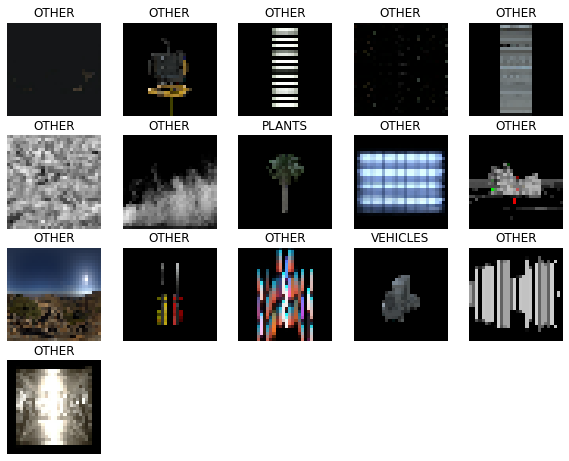

In [24]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [25]:
initial_bias = np.log([(COUNT_OTHER+COUNT_VEHICLES)/COUNT_PLANTS])
initial_bias

array([2.11607567])

In [26]:
weight_for_0 = (1 / COUNT_OTHER)*(TRAIN_IMG_COUNT)/3.0 
weight_for_1 = (1 / COUNT_PLANTS)*(TRAIN_IMG_COUNT)/3.0
weight_for_2 = (1 / COUNT_VEHICLES)*(TRAIN_IMG_COUNT)/3.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 0.43
Weight for class 1: 3.10
Weight for class 2: 2.97


In [148]:
from tensorflow import keras
from tensorflow.python.keras import layers

model = keras.Sequential([
    # Data augmentation is not included in the model because images are only taken in a specific orientation, and variations such as flips and rotations not presented if train and test images.
    
    # Block One
    layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same',
                  input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3]),
    layers.MaxPool2D(),
    tf.keras.layers.BatchNormalization(),
    # Block Two
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    tf.keras.layers.BatchNormalization(),
    layers.Dropout(0.8),
    
    #Dense layers
    
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='relu'),,
    layers.Dense(3, activation='softmax'),
])

In [149]:
model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics='sparse_categorical_accuracy'
    )

In [150]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // (BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // (BATCH_SIZE),
    class_weight=class_weight,
)

Epoch 1/100
77/77 [==============================] - 2s 14ms/step - loss: 1.3364 - sparse_categorical_accuracy: 0.3157 - val_loss: 0.9658 - val_sparse_categorical_accuracy: 0.6513
Epoch 2/100
77/77 [==============================] - 1s 11ms/step - loss: 0.8961 - sparse_categorical_accuracy: 0.5398 - val_loss: 0.7456 - val_sparse_categorical_accuracy: 0.6678
Epoch 3/100
77/77 [==============================] - 1s 11ms/step - loss: 0.7000 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.6834 - val_sparse_categorical_accuracy: 0.6447
Epoch 4/100
77/77 [==============================] - 1s 12ms/step - loss: 0.6637 - sparse_categorical_accuracy: 0.6859 - val_loss: 0.4320 - val_sparse_categorical_accuracy: 0.8750
Epoch 5/100
77/77 [==============================] - 1s 12ms/step - loss: 0.5422 - sparse_categorical_accuracy: 0.7638 - val_loss: 0.5399 - val_sparse_categorical_accuracy: 0.7566
Epoch 6/100
77/77 [==============================] - 1s 11ms/step - loss: 0.4697 - sparse_categorica

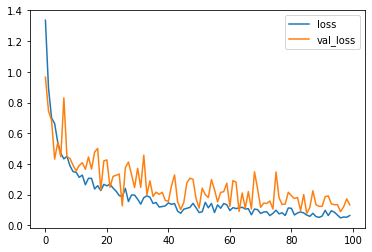

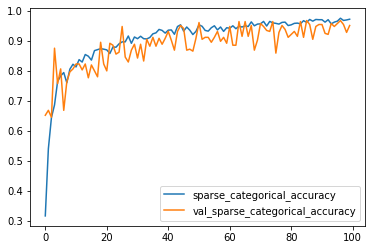

In [151]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [ ]:
pred = model.predict(test_ds)
predictions = np.argmax(pred, axis=-1)
probability = np.max(pred, axis=-1)
labels = {1:'Plants',2:'Vehicles'}
results = [(test_filenames[i].split('\\')[-1], "{:.3%}".format(probability[i]), labels[predictions[i]]) for i, v in enumerate(predictions.tolist()) if predictions[i] == 1 or predictions[i] == 2]
[i for i in results if i]